![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
import re
import ast
import datetime

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/cost-of-living-index/cost_of_living_index.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
31882,id_5860,Paris,"['French', 'Bar', 'European']",5861.0,$$ - $$$,141.0,"[['Excellent.', 'Hidden uphill from Belleville...",/Restaurant_Review-g187147-d719482-Reviews-Le_...,d719482,1,3.0
5955,id_5955,Prague,"['European', 'Czech']",2913.0,$,11.0,"[['Smoking during the lunch', 'Czech food - cz...",/Restaurant_Review-g274707-d4769636-Reviews-Ho...,d4769636,0,0.0
3780,id_3780,Prague,"['International', 'European', 'Czech', 'Easter...",445.0,$$ - $$$,212.0,"[['nice restaurant - good food', 'Great place ...",/Restaurant_Review-g274707-d7123543-Reviews-Na...,d7123543,0,0.0
26721,id_1034,Athens,"['Italian', 'Greek']",1036.0,$$ - $$$,NaN,"[['Delicious and cheap'], ['12/19/2016']]",/Restaurant_Review-g189400-d10807908-Reviews-T...,d10807908,1,5.0
47232,id_6056,Madrid,"['Mexican', 'American', 'International', 'Span...",6059.0,$$ - $$$,33.0,"[[], []]",/Restaurant_Review-g187514-d8835808-Reviews-Ca...,d8835808,1,3.0


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [15]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [16]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [17]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [18]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [19]:
save_City = data['City']
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
data['City'] = save_City

In [20]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,City
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,1,0,0,0,0,0,0,0,Paris
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,Helsinki
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,Edinburgh
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,London
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,Bratislava


In [21]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,City
8055,id_8055,"['Italian', 'Pizza', 'Seafood', 'Mediterranean...",1605.0,$$ - $$$,1030.0,"[['An Enjoyable Meal', 'Very nice place'], ['1...",/Restaurant_Review-g187791-d12512021-Reviews-H...,d12512021,0,0.0,...,0,0,0,1,0,0,0,0,0,Rome
7957,id_7957,"['Italian', 'Pizza', 'Seafood', 'Vegetarian Fr...",1842.0,$$ - $$$,506.0,"[['Great local pizzeria', 'Bad experience'], [...",/Restaurant_Review-g187791-d801494-Reviews-La_...,d801494,0,0.0,...,0,0,0,1,0,0,0,0,0,Rome
7323,id_7323,NaN,2321.0,NaN,4.0,"[[""Very good but remember: it's not a fully......",/Restaurant_Review-g1891930-d11661876-Reviews-...,d11661876,0,0.0,...,0,0,0,0,0,0,0,0,0,Brussels
9258,id_9258,"['Mediterranean', 'European', 'Greek']",600.0,$$ - $$$,57.0,"[['Good food and exceptional service', 'Best G...",/Restaurant_Review-g187309-d2289781-Reviews-Te...,d2289781,0,0.0,...,0,0,0,0,0,0,0,0,0,Munich
17413,id_2631,"['French', 'Bar', 'European', 'Vegetarian Frie...",2632.0,$$ - $$$,146.0,"[['SIX + 1 out of 10', 'Good friendly family r...",/Restaurant_Review-g187147-d1198153-Reviews-Ca...,d1198153,1,4.0,...,0,1,0,0,0,0,0,0,0,Paris


#### Возьмем следующий признак "Price Range".

In [22]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [23]:
PRICE_RANGE_TRANSLATE = {
    '$': 1,
    '$$ - $$$': 2,
    '$$$$': 3,
}

data['price_range']= data['Price Range'].apply(PRICE_RANGE_TRANSLATE.get)
data['price_range_is_NAN'] = data['price_range'].isna()
data['price_range'].fillna(2, inplace=True)

In [24]:
data[['price_range_is_NAN', 'price_range']].sample(5)

,price_range_is_NAN,price_range
47655,False,2.0
15581,True,2.0
47408,False,1.0
618,False,2.0
3818,False,2.0


> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [25]:
def to_str_list(val):
    if isinstance(val, str):
        try:
            literal = ast.literal_eval(val)
        except:
            pass
        else:
            if isinstance(literal, list) and all(isinstance(e, str) for e in literal):
                return literal
    return []


def to_pipe_separated(val):
    return '|'.join(to_str_list(val))

In [26]:

cuisines = data['Cuisine Style'].apply(to_pipe_separated).str.get_dummies()

In [27]:
cuisines.sample(5)

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
32656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8761,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25420,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
#data[cuisines.add_prefix('cuisine_').columns] = cuisines

In [29]:
data['Reviews'].sample(5)

17203                                             [[], []]
21084                                             [[], []]
38398    [['Best burger ever', 'Great time and deliciou...
33601                                             [[], []]
18563    [['Good place for BBQ foods', 'Lovely lunch'],...
Name: Reviews, dtype: object

In [30]:
def parse_reviews(val):
    last_date = between_last_dates = None
    if isinstance(val, str):
        try:
            literal = ast.literal_eval(val)
        except:
            pass
        else:
            if isinstance(literal, list) \
                    and len(literal) == 2 \
                    and isinstance(literal[1], list):
                timestamps = []
                for elem in literal[1]:
                    if isinstance(elem, str):
                        try:
                            d = datetime.datetime.strptime(elem, '%m/%d/%Y')
                        except ValueError:
                            pass
                        else:
                            timestamps.append(d.timestamp())
                if len(timestamps) >= 1:
                    last_date = timestamps[-1]
                    if len(timestamps) >= 2:
                        between_last_dates = last_date - timestamps[-2]
    return last_date, between_last_dates

In [31]:
data[['last_date', 'between_last_dates']] = pd.DataFrame.from_records(data['Reviews'].apply(parse_reviews))
data['last_date_is_na'] = data['last_date'].isna() 
data['last_date'].fillna(data['last_date'].mean(), inplace=True)
data['between_last_dates_is_na'] = data['between_last_dates'].isna() 
data['between_last_dates'].fillna(data['between_last_dates'].mean(), inplace=True)

In [32]:
data[['last_date', 'last_date_is_na', 'between_last_dates','between_last_dates_is_na']].sample(5)

,last_date,last_date_is_na,between_last_dates,between_last_dates_is_na
37662,1.507421e+09,False,-6.134400e+06,False
23363,1.510618e+09,False,-2.073600e+06,False
32569,1.484562e+09,True,-1.077675e+07,True
40753,1.499645e+09,False,-1.304640e+07,False
28288,1.484562e+09,True,-1.077675e+07,True


![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

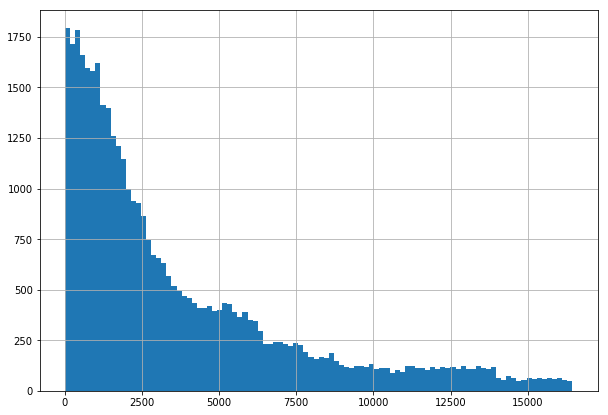

In [33]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

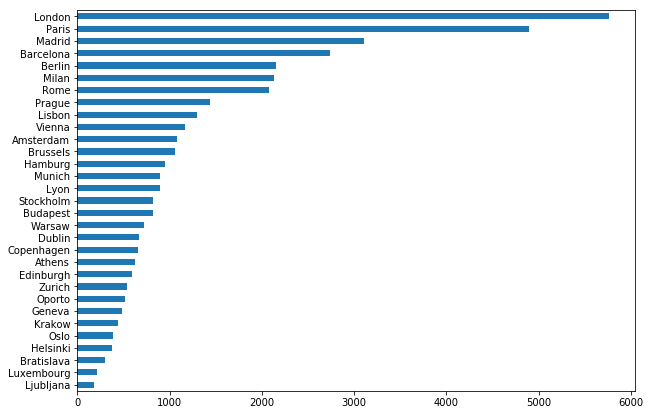

In [34]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

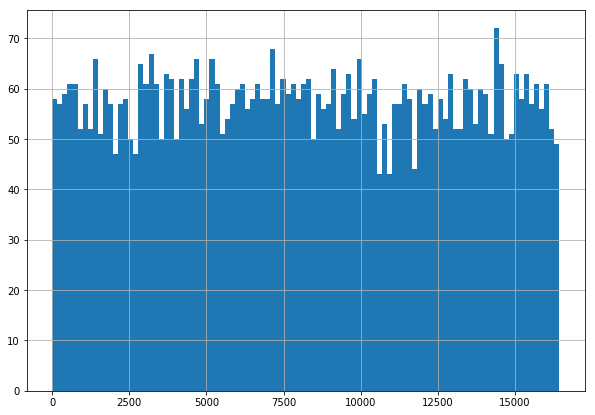

In [35]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

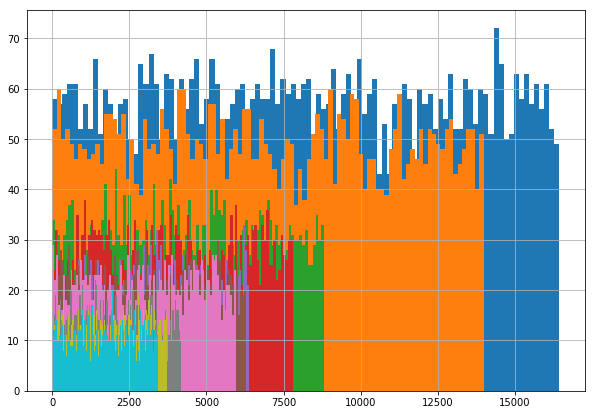

In [36]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


In [37]:
data['ranking_norm'] = data['Ranking'] / (data).groupby('City')['Ranking'].transform('max')

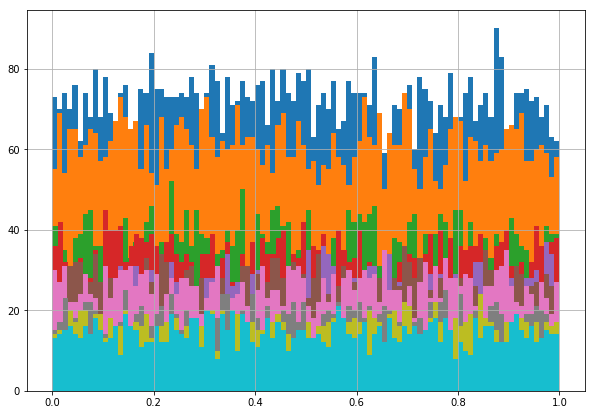

In [38]:
for x in (data['City'].value_counts())[0:10].index:
    data['ranking_norm'][data['City'] == x].hist(bins=100)
plt.show()

In [39]:
data['ranking_by_count'] = data['Ranking'] / (data).groupby('City')['City'].transform('count')

### Посмотрим распределение целевой переменной

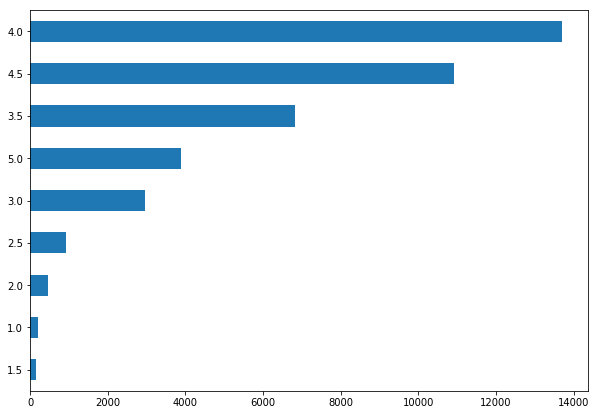

In [40]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

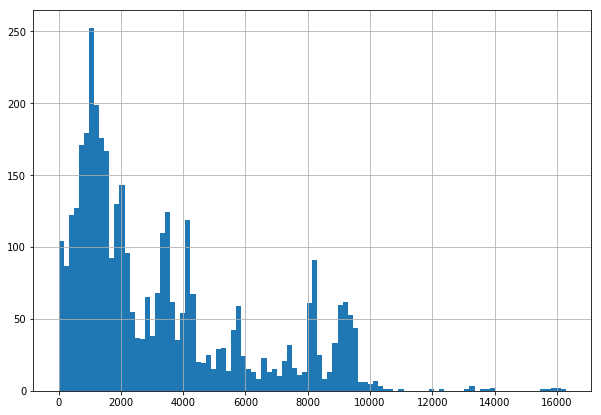

In [41]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

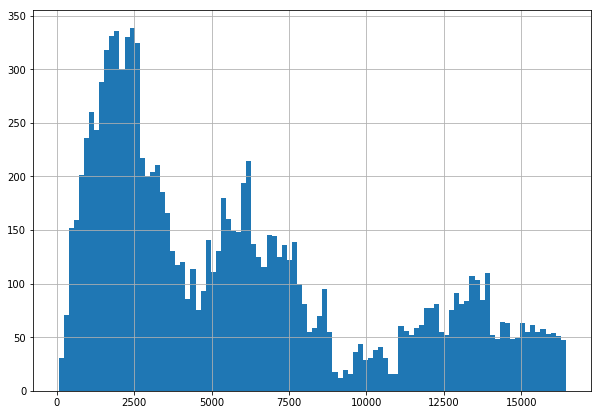

In [42]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

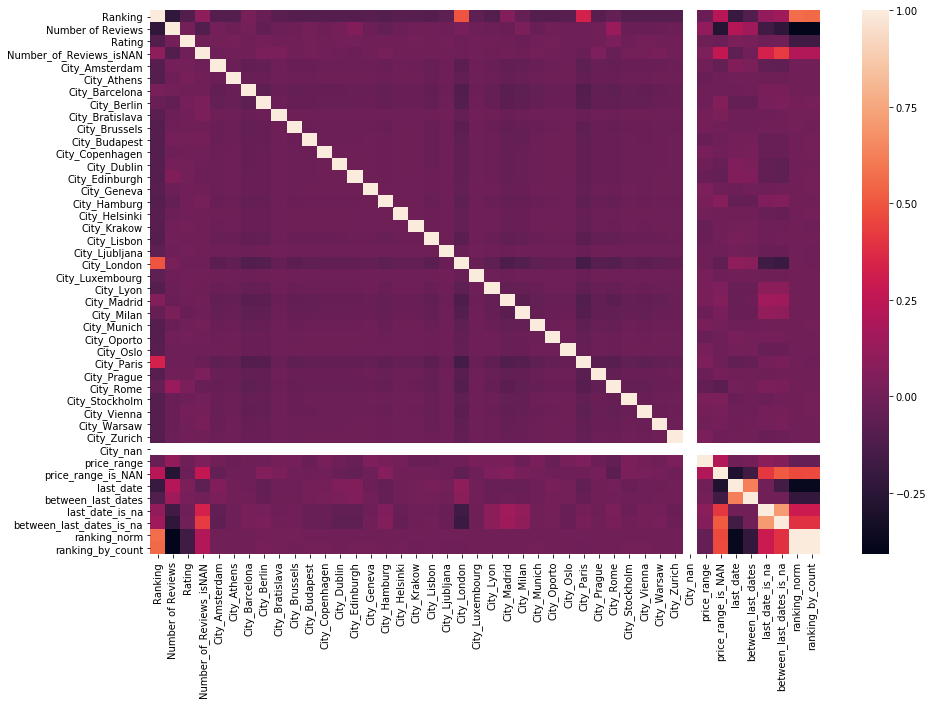

In [43]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

In [44]:
cuisines_popularity = cuisines.sum()
cuisines_popularity

Afghani         27
African        193
Albanian         8
American      1642
Arabic          58
              ... 
Vietnamese     622
Welsh            3
Wine Bar       877
Xinjiang         1
Yunnan           2
Length: 125, dtype: int64

In [45]:
data['cuisines_popularity'] = data['Cuisine Style'].apply(lambda val: sum(cuisines_popularity[c] for c in to_str_list(val)))

In [46]:
data['cuisines_popularity'].sample(10)

15461    31152
41157     2122
20790    10245
1964      1446
33194     5578
7483      3456
35592    24864
46975    37858
48479     1860
47166    38326
Name: cuisines_popularity, dtype: int64

In [47]:
cuisines_populaity_by_city = {}
for idx, row in data.iterrows():
    weight = 1.0 - row['ranking_norm']
    city_dict = cuisines_populaity_by_city.setdefault(row['City'], {})
    for cuisine in to_str_list(row['Cuisine Style']):
        city_dict[cuisine] = city_dict.get(cuisine, 0.0) + weight    

In [48]:
data['cuisines_populaity_in_city'] = data.apply(
    lambda row: sum(
        cuisines_populaity_by_city[row['City']][cuisine]
        for cuisine in to_str_list(row['Cuisine Style'])
    ), 
    axis=1
)

In [49]:
data['cuisines_populaity_in_city'].sample(10)

42674     272.955422
30532    1414.366581
25379    1729.564905
37356      63.238776
43176    1872.424996
2304     2060.528764
39589       0.000000
21837    1623.219435
43518    1653.246469
18594     808.939248
Name: cuisines_populaity_in_city, dtype: float64

In [50]:
chain_count = data.groupby('ID_TA')['ID_TA'].count()
data['in_chain'] = data['ID_TA'].apply(chain_count[chain_count > 1].__contains__)

In [51]:
data['in_chain'].value_counts()

False    49926
True        74
Name: in_chain, dtype: int64

In [52]:
df_cost_of_living = pd.read_csv('../input/cost-of-living-index/cost_of_living_index.csv')

In [53]:
df_cost_of_living.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 3 columns):
City                    571 non-null object
State                   571 non-null object
Cost of Living Index    571 non-null float64
dtypes: float64(1), object(2)
memory usage: 13.5+ KB


In [54]:
df_cost_of_living.sample(5)

,City,State,Cost of Living Index
289,Barcelona,Spain,61.34
481,Gurgaon,India,33.87
399,Poznan,Poland,40.88
483,Guadalajara,Mexico,33.80
359,Abidjan,Ivory Coast,47.45


In [55]:
df_cost_of_living[df_cost_of_living['City'].duplicated(keep=False)].sort_values(by='City')

,City,State,Cost of Living Index
104,Birmingham,AL,75.49
242,Birmingham,United Kingdom,65.88
0,Hamilton,Bermuda,150.02
90,Hamilton,New Zealand,76.46
229,Hamilton,Canada,66.71
214,Kingston,Canada,68.17
342,Kingston,Jamaica,50.79
36,London,United Kingdom,84.65
201,London,Canada,69.23
129,San Jose,CA,73.59


In [56]:
df_cost_of_living.drop([104, 201], inplace=True)

In [57]:
data = data.merge(df_cost_of_living, on='City', how='left')
data.shape

(50000, 57)

In [58]:
data[data['Cost of Living Index'].isna()]['City'].value_counts()

Oporto    642
Krakow    554
Name: City, dtype: int64

In [59]:
pd.get_dummies(data, columns=['State'], dummy_na=True).sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,State_Norway,State_Poland,State_Portugal,State_Slovakia,State_Slovenia,State_Spain,State_Sweden,State_Switzerland,State_United Kingdom,State_nan
4771,id_4771,['Sushi'],2509.0,$$ - $$$,42.0,"[['Not bad for a shopping centre food court', ...",/Restaurant_Review-g189158-d5568779-Reviews-Ki...,d5568779,0,0.0,...,0,0,1,0,0,0,0,0,0,0
49916,id_2342,NaN,2346.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187331-d12593957-Reviews-C...,d12593957,1,3.5,...,0,0,0,0,0,0,0,0,0,0
20217,id_3705,['Mediterranean'],3707.0,NaN,11.0,"[[], []]",/Restaurant_Review-g187849-d3212144-Reviews-Ca...,d3212144,1,4.5,...,0,0,0,0,0,0,0,0,0,0
20792,id_1492,NaN,1495.0,NaN,10.0,"[['Delicious Thai food, great drinks', 'Nice s...",/Restaurant_Review-g188590-d12146830-Reviews-B...,d12146830,1,5.0,...,0,0,0,0,0,0,0,0,0,0
25457,id_1673,NaN,1675.0,NaN,0.0,"[[], []]",/Restaurant_Review-g189400-d12786386-Reviews-T...,d12786386,1,3.0,...,0,0,0,0,0,0,0,0,0,0


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [60]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [61]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    # Закомментированны попытки, не уменьшающие ошибку.
    
    df_output = df_input.copy()
    
    df_output = df_output.merge(df_cost_of_living, on='City', how='left')
    assert df_output.shape[0] == df_input.shape[0]
        
    df_output['Number_of_Reviews_isNAN'] = df_output['Number of Reviews'].isna()
    df_output['Number of Reviews'].fillna(0, inplace=True)
#     df_output['Number of Reviews'].fillna(df_output['Number of Reviews'].min(), inplace=True)
#     df_output['Number of Reviews'].fillna(df_output['Number of Reviews'].max(), inplace=True)
#     df_output['Number of Reviews'].fillna(df_output['Number of Reviews'].mean(), inplace=True)
        
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    df_output['City'] = df_input['City']
    
    df_output['price_range'] = df_output['Price Range'].apply(PRICE_RANGE_TRANSLATE.get)
    df_output['price_range_is_NAN'] = df_output['price_range'].isna()
#     df_output['price_range'].fillna(1, inplace=True)
    df_output['price_range'].fillna(2, inplace=True)
#     df_output['price_range'].fillna(3, inplace=True)
    
    df_output[cuisines.add_prefix('cuisine_').columns] = cuisines
    
    df_output[['last_date', 'between_last_dates']] = pd.DataFrame.from_records(df_output['Reviews'].apply(parse_reviews))
    df_output['last_date_is_na'] = df_output['last_date'].isna() 
#     df_output['last_date'].fillna(0, inplace=True)
#     df_output['last_date'].fillna(datetime.datetime(9999, 1, 1).timestamp(), inplace=True)
    df_output['last_date'].fillna(df_output['last_date'].mean(), inplace=True)
#     df_output['last_date'].fillna(df_output.groupby('City')['last_date'].transform('mean'), inplace=True)
    df_output['between_last_dates_is_na'] = df_output['between_last_dates'].isna() 
#     df_output['between_last_dates'].fillna(0, inplace=True)
#     df_output['between_last_dates'].fillna(9e9, inplace=True)
#     df_output['between_last_dates'].fillna(df_output['between_last_dates'].mean(), inplace=True)
    df_output['between_last_dates'].fillna(df_output.groupby('City')['between_last_dates'].transform('mean'), inplace=True)

    df_output['ranking_norm'] = df_output['Ranking'] / df_output.groupby('City')['Ranking'].transform('max')
    df_output['ranking_by_count'] = df_output['Ranking'] / df_output.groupby('City')['City'].transform('count')
    
#     df_output.drop('Ranking', axis = 1, inplace=True)

    df_output['nof_reviews_norm'] = df_output['Number of Reviews'] / df_output.groupby('City')['Number of Reviews'].transform('max')    
#     df_output.drop(['Number of Reviews'], axis = 1, inplace=True)

#     df_output['in_chain'] = df_output['ID_TA'].apply(chain_count[chain_count > 1].__contains__)

#     df_output['cuisines_popularity'] = df_output['Cuisine Style'].apply(lambda val: sum(cuisines_popularity[c] for c in to_str_list(val)))

#     df_output['cuisines_populaity_in_city'] = df_output.apply(
#         lambda row: sum(
#             cuisines_populaity_by_city[row['City']][cuisine]
#             for cuisine in to_str_list(row['Cuisine Style'])
#         ), 
#         axis=1
#     )


#     df_output['Cost of Living Index'].fillna(df_output['Cost of Living Index'].min(), inplace=True)
#     df_output['Cost of Living Index'].fillna(df_output['Cost of Living Index'].mean(), inplace=True)
    df_output['Cost of Living Index'].fillna(df_output['Cost of Living Index'].max(), inplace=True)
    
    df_output['price_range_by_cost_of_living'] = df_output['price_range'] / df_output.groupby('City')['Cost of Living Index'].transform('max')
    
#     df_output = pd.get_dummies(df_output, columns=['State'], dummy_na=True)

    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [62]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,Cost of Living Index,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,cuisine_Xinjiang,cuisine_Yunnan,last_date,between_last_dates,last_date_is_na,between_last_dates_is_na,ranking_norm,ranking_by_count,nof_reviews_norm,price_range_by_cost_of_living
13553,2724.0,14.0,1,4.0,52.54,False,0,0,0,0,...,0,0,1.418083e+09,-9.917439e+06,False,True,0.732849,1.653916,0.004113,0.038066
41595,1358.0,41.0,1,3.0,127.21,False,0,0,0,0,...,0,0,1.494547e+09,-7.171200e+06,False,False,0.915094,2.115265,0.012789,0.015722
18814,2820.0,19.0,1,4.0,58.70,False,0,0,0,0,...,0,0,1.484562e+09,-1.299247e+07,True,True,0.320127,0.739575,0.003160,0.034072
41090,12779.0,44.0,1,3.0,84.56,False,0,0,0,0,...,0,0,1.435709e+09,-6.937920e+07,False,False,0.913699,2.092174,0.005773,0.011826
48713,1371.0,3.0,1,4.5,57.07,False,0,1,0,0,...,0,0,1.483315e+09,-1.010058e+07,False,True,0.767208,1.766753,0.000709,0.017522
43302,3218.0,18.0,1,4.5,73.94,False,0,0,0,0,...,0,0,1.484562e+09,-1.419687e+07,True,True,0.512829,1.194506,0.002830,0.027049
15922,1113.0,194.0,1,4.5,73.94,False,0,0,0,0,...,0,0,1.488672e+09,-2.341440e+07,False,False,0.177371,0.413140,0.030503,0.027049
31775,1047.0,35.0,1,4.5,50.13,False,0,0,0,0,...,0,0,1.490486e+09,-1.391040e+07,False,False,0.250000,0.576542,0.007742,0.039896
9072,2401.0,24.0,0,0.0,61.34,False,0,0,1,0,...,0,0,1.492560e+09,-3.110400e+06,False,False,0.307978,0.707216,0.004804,0.032605
43490,9660.0,49.0,1,3.5,84.56,False,0,0,0,0,...,0,0,1.486858e+09,-1.296000e+06,False,False,0.690691,1.581532,0.006429,0.023652


In [63]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 173 entries, Ranking to price_range_by_cost_of_living
dtypes: bool(4), float64(11), int64(126), uint8(32)
memory usage: 55.6 MB


In [64]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [65]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [66]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 172), (40000, 172), (40000, 171), (32000, 171), (8000, 171))

# Model 
Сам ML

In [67]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [68]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [69]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [70]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19734875


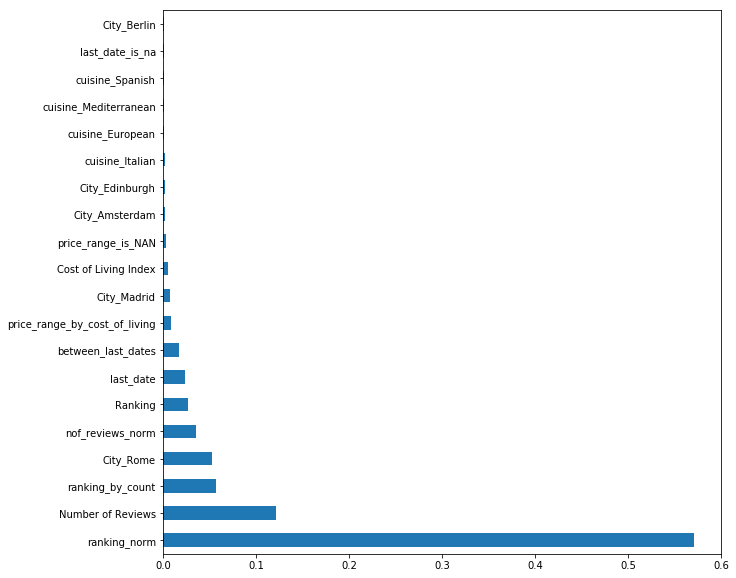

In [71]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [72]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Cost of Living Index,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,cuisine_Xinjiang,cuisine_Yunnan,last_date,between_last_dates,last_date_is_na,between_last_dates_is_na,ranking_norm,ranking_by_count,nof_reviews_norm,price_range_by_cost_of_living
7733,253.0,228.0,0.0,52.54,False,0,0,0,0,0,...,0,0,1.518048e+09,-9.504000e+05,False,False,0.068066,0.153613,0.066980,0.038066
9544,2756.0,0.0,0.0,79.89,True,1,0,0,0,0,...,0,0,1.496448e+09,-6.483701e+06,False,True,0.846958,2.008746,0.000000,0.025034
5781,388.0,248.0,0.0,127.21,False,0,0,0,0,0,...,0,0,1.511482e+09,-2.851200e+06,False,False,0.311897,0.700361,0.053819,0.015722
4469,3696.0,13.0,0.0,69.31,False,0,0,0,1,0,...,0,0,1.461024e+09,-1.797120e+07,False,False,0.580038,1.366359,0.005054,0.028856
5864,1270.0,843.0,0.0,84.65,False,0,0,0,0,0,...,0,0,1.510704e+09,-3.456000e+05,False,False,0.077232,0.176561,0.087267,0.023627
5430,1808.0,6.0,0.0,76.80,False,0,0,0,0,0,...,0,0,1.484562e+09,-1.720166e+07,True,True,0.678170,1.605684,0.003072,0.026042
3540,1969.0,13.0,0.0,67.24,False,0,0,0,0,0,...,0,0,1.506902e+09,-6.652800e+06,False,False,0.571719,1.364518,0.002633,0.029744
4890,2531.0,167.0,0.0,71.76,False,0,0,0,0,0,...,0,0,1.478822e+09,-1.753920e+07,False,False,0.425521,0.977598,0.018707,0.027871
9583,2415.0,32.0,0.0,69.31,False,0,0,0,1,0,...,0,0,1.503792e+09,1.771200e+07,False,False,0.379002,0.892791,0.012442,0.014428
3189,451.0,77.0,0.0,57.07,False,0,1,0,0,0,...,0,0,1.510531e+09,-1.209600e+06,False,False,0.252378,0.581186,0.018186,0.035045


In [73]:
test_data = test_data.drop(['Rating'], axis=1)

In [74]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [75]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [76]:
predict_submission

array([3.03 , 4.19 , 4.4  , ..., 3.095, 4.5  , 4.32 ])

In [77]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.030
1,id_1,4.190
2,id_2,4.400
3,id_3,4.335
4,id_4,4.505
5,id_5,4.460
6,id_6,1.890
7,id_7,2.930
8,id_8,4.375
9,id_9,4.710


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
